<a href="https://colab.research.google.com/github/cidcom/satellite-cloud-removal-dip/blob/main/01-Example-Use-colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# GitHub import and package installation
These two actions should take about 1-2 minutes. Then you're ready to go.

In [2]:
! git clone https://github.com/cidcom/satellite-cloud-removal-dip

fatal: destination path 'satellite-cloud-removal-dip' already exists and is not an empty directory.


In [5]:
!pip install -q torch==1.10.0 torchvision numpy==1.20 rasterio==1.0.21 git+https://github.com/PyTorchLightning/pytorch-lightning

In [6]:
import sys
sys.path.append('./satellite-cloud-removal-dip/')

from src import *
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (20, 10)

### Example Cloud Image with a Cloud-Shadow Mask

In [9]:
s2_image = s2_preprocess('./satellite-cloud-removal-dip/data/example_sample/S2/S1_3c120554-3873-4de2-bcc3-23ae00d28c4f_S2_76dac503-47d7-446b-b92d-56f4dd10f8e2_0_0_256x256.tif')

with open('./satellite-cloud-removal-dip/data/example_sample/mask.npy', 'rb') as f:
    mask = np.load(f)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


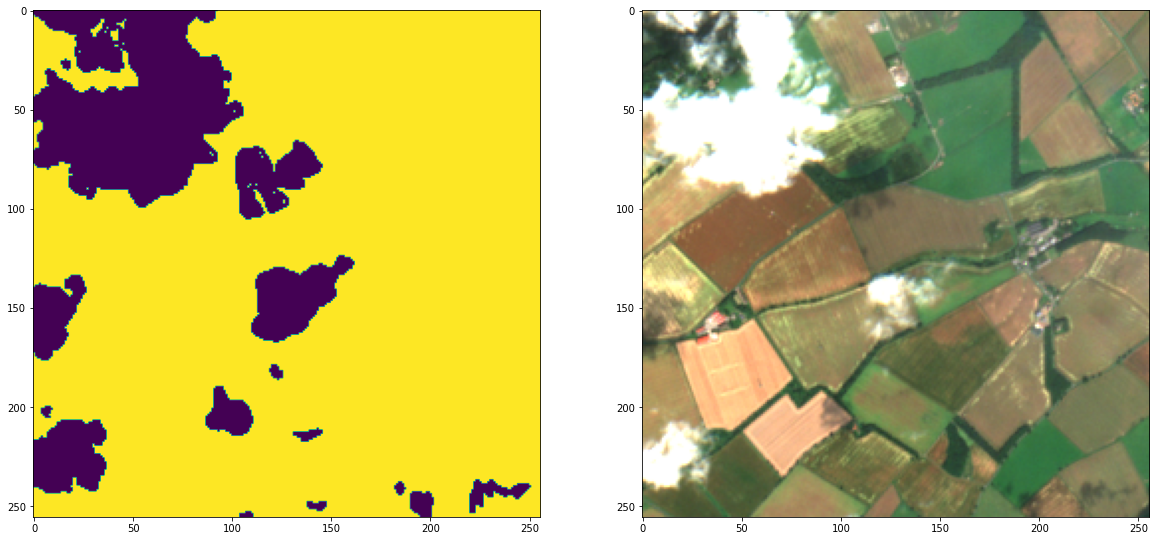

In [10]:
plt.subplot(1,2,1)
plt.imshow(mask)
plt.subplot(1,2,2)
plt.imshow(s2_image)

### Supporting Data: Sentinel-1 SAR and a yearly Sentinel-2 average from 2019

In [11]:
s1_image = s1_preprocess('./satellite-cloud-removal-dip/data/example_sample/S1/S1_3c120554-3873-4de2-bcc3-23ae00d28c4f_S2_76dac503-47d7-446b-b92d-56f4dd10f8e2_0_0_256x256.tif',
                         to_db = True)

with open('./satellite-cloud-removal-dip/data/2019_mean.npy', 'rb') as f:
    s2_mean = np.load(f)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


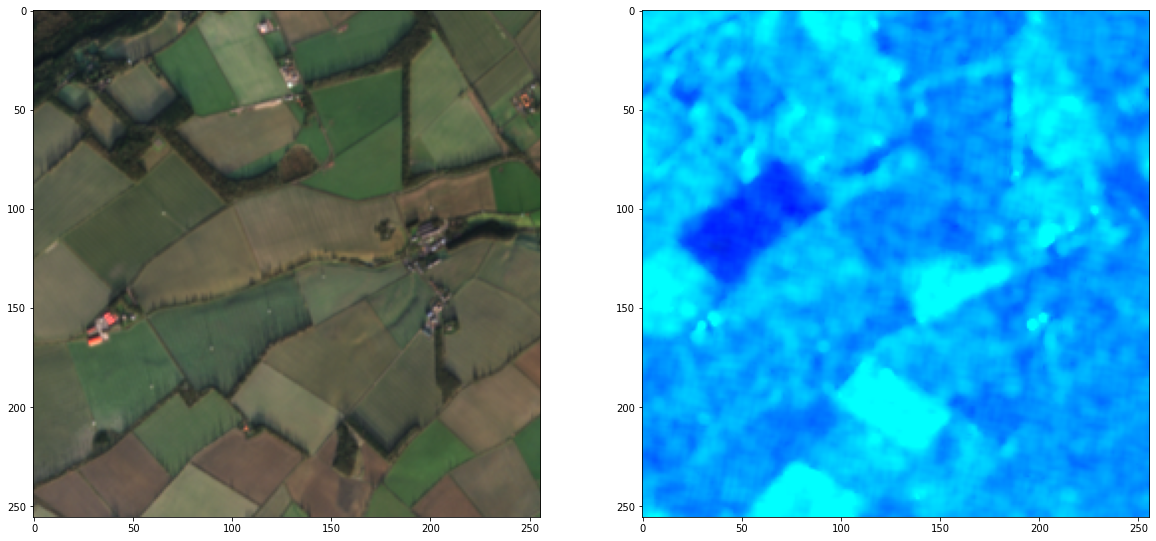

In [12]:
plt.subplot(1,2,1)
plt.imshow(s2_mean)
plt.subplot(1,2,2)
plt.imshow(rgb(s1_image))

### Initialize Model

In [13]:
my_model = LitDIP()

my_model.set_target([s2_image, s2_mean, s1_image])
my_model.set_mask([mask,
                   np.ones(mask.shape),
                   np.ones(mask.shape)])

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
trainer = pl.Trainer(
    max_epochs = 4,            
    checkpoint_callback=False,
    logger=False,
    #gpus = [0]
)
trainer.fit(my_model)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:152: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/configuration_validator.py:318: LightningDeprecationWarning: The `LightningModule.on_pretrain_routine_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `LightningModule.on_fit_start` instead.
  f"The `LightningModule.{hook}` hook was deprecated in v1.6 and"

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 2.4 M 
-------------------------------------
2.4 M     Train

Training: 0it [00:00, ?it/s]

In [15]:
result, _, _ = my_model.output() # the two unused (_) variables correspond to s2_mean reconstruction and s1_image reconstruction

In [ ]:
plt.subplot(1,3,1)
plt.imshow(mask)
plt.axis('off')
plt.title('Cloud Mask')
plt.subplot(1,3,2)
plt.imshow(s2_image)
plt.axis('off')
plt.title('Cloud Mask')
plt.subplot(1,3,3)
plt.imshow(result)
plt.axis('off')
plt.title('Results')